In [1]:
!pip3 install -q -U tensorflow-addons

In [1]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Lambda
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D,MaxPooling2D,Input,BatchNormalization,ReLU,Flatten,Dense,AveragePooling2D,Dropout
import random
from keras import backend as K
from keras.optimizers import Adam,SGD,RMSprop
import tensorflow_addons as tfa
from tensorflow.keras.activations import relu,sigmoid,tanh,softmax
from tensorflow.keras.losses import binary_crossentropy

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [20]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

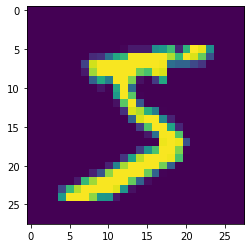

In [5]:
plt.imshow(X_train[0])

In [4]:
X_train = X_train/255.0
X_test = X_test/255.0

In [5]:
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

In [6]:
def make_pairs(images, labels):
    pairImages,pairLabels = [],[]
    idx = [np.where(labels == i)[0] for i in range(0,10)]
    for idxA in range(len(images)):
        #pos image
        currentImage = images[idxA]
        idxB = np.random.choice(idx[labels[idxA]])
        snd_pos_img = images[idxB]
        pairImages.append([currentImage,snd_pos_img])
        pairLabels.append([1])
        #neg pair image
        negIdx = np.where(labels != labels[idxA])[0]
        idxC = np.random.choice(negIdx)
        negImage = images[idxC]
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    return (pairImages,pairLabels)

In [7]:
train_pairs, train_y =np.arrray(make_pairs(X_train, y_train))
test_pairs, test_y =np.array(make_pairs(X_test, y_test))

In [10]:
np.array(train_pairs).shape,np.array(test_pairs).shape,np.array(train_y).shape,np.array(test_y).shape

((120000, 2, 28, 28, 1), (20000, 2, 28, 28, 1), (120000, 1), (20000, 1))

In [11]:
type(test_pairs)

numpy.ndarray

In [15]:
model = models.Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='tanh'))


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                19610     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [16]:
left_input = Input((28,28,1))
right_input = Input((28,28,1))

encoded_l = model(left_input)
encoded_r = model(right_input)
type(encoded_l)

tensorflow.python.keras.engine.keras_tensor.KerasTensor

In [1]:
def euclid_dis(vects):
  x,y = vects[0:2]
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [16]:
distance = Lambda(euclid_dis)([encoded_l, encoded_r])
outputs = Dense(1, activation="sigmoid")(distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=outputs)

In [ ]:
siamese_net.compile(loss="binary_crossentropy", optimizer='Adam', metrics=['accuracy'])
history=siamese_net.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y[:],
          batch_size=64,
          epochs=10,
          validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y[:]))

Epoch 1/10
1875/1875 [==============================] - 106s 56ms/step - loss: 0.3722 - accuracy: 0.8568 - val_loss: 0.2743 - val_accuracy: 0.9137
Epoch 2/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.2850 - accuracy: 0.9046 - val_loss: 0.2448 - val_accuracy: 0.9255
Epoch 3/10
1875/1875 [==============================] - 112s 59ms/step - loss: 0.2554 - accuracy: 0.9142 - val_loss: 0.2326 - val_accuracy: 0.9275
Epoch 4/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.2375 - accuracy: 0.9219 - val_loss: 0.2116 - val_accuracy: 0.9301
Epoch 5/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.2216 - accuracy: 0.9248 - val_loss: 0.1580 - val_accuracy: 0.9479
Epoch 6/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.1732 - accuracy: 0.9422 - val_loss: 0.1074 - val_accuracy: 0.9686
Epoch 7/10
1875/1875 [==============================] - 120s 64ms/step - loss: 0.1339 - accuracy: 0.9574 - val_loss: 0

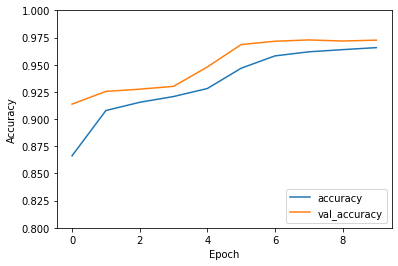

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

In [26]:
l=tfa.losses.TripletSemiHardLoss()
siamese_net.compile(loss=l, optimizer='SGD')
history=siamese_net.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y[:],
          batch_size=64,
          epochs=3,
          validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y[:]))

Epoch 1/3
1875/1875 [==============================] - 81s 43ms/step - loss: 0.9940 - val_loss: 0.9834
Epoch 2/3
1875/1875 [==============================] - 77s 41ms/step - loss: 0.9898 - val_loss: 0.9786
Epoch 3/3
1875/1875 [==============================] - 76s 41ms/step - loss: 0.9882 - val_loss: 0.9756


In [25]:
l=tfa.losses.ContrastiveLoss()
siamese_net.compile(loss=l, optimizer='SGD')
history=siamese_net.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y[:],
          batch_size=128,
          epochs=3,
          validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y[:]))

Epoch 1/3
938/938 [==============================] - 63s 67ms/step - loss: 0.2470 - val_loss: 0.2351
Epoch 2/3
938/938 [==============================] - 62s 66ms/step - loss: 0.2424 - val_loss: 0.2232
Epoch 3/3
938/938 [==============================] - 62s 67ms/step - loss: 0.2364 - val_loss: 0.2119


In [ ]:
l=tfa.losses.TripletSemiHardLoss()
siamese_net.compile(loss=l, optimizer='RMSprop', metrics=['accuracy'])
history=siamese_net.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y[:],
          batch_size=128,
          epochs=5,
          validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y[:]))

938/938 [==============================] - 265s 281ms/step - loss: 0.6028 - accuracy: 0.6210 - val_loss: 0.4274 - val_accuracy: 0.8249


In [ ]:
siamese_net.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
siamese_net.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y[:],
          batch_size=64,
          epochs=10,
          validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y[:]))

Epoch 1/10
1875/1875 [==============================] - 281s 149ms/step - loss: 0.3362 - accuracy: 0.8723 - val_loss: 0.2920 - val_accuracy: 0.8895
Epoch 2/10
1875/1875 [==============================] - 279s 149ms/step - loss: 0.3039 - accuracy: 0.8836 - val_loss: 0.2944 - val_accuracy: 0.8950
Epoch 3/10
1875/1875 [==============================] - 278s 148ms/step - loss: 0.2829 - accuracy: 0.8907 - val_loss: 0.2909 - val_accuracy: 0.9003
Epoch 4/10
1875/1875 [==============================] - 278s 148ms/step - loss: 0.2811 - accuracy: 0.8907 - val_loss: 0.2982 - val_accuracy: 0.8999
Epoch 5/10
1875/1875 [==============================] - 278s 148ms/step - loss: 0.2755 - accuracy: 0.8914 - val_loss: 0.3026 - val_accuracy: 0.8977
Epoch 6/10
1875/1875 [==============================] - 278s 148ms/step - loss: 0.2770 - accuracy: 0.8915 - val_loss: 0.2936 - val_accuracy: 0.9012
Epoch 7/10
1875/1875 [==============================] - 278s 148ms/step - loss: 0.2725 - accuracy: 0.8926 - val_

(0.85, 0.95)

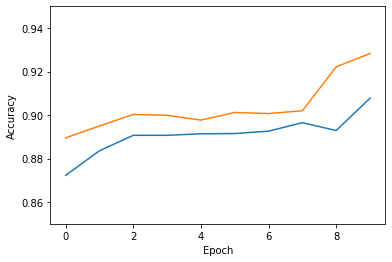

In [2]:
acc=[0.8723,0.8836,0.8907,0.8907,0.8914,0.8915,0.8926,0.8965,0.8929,0.9078]
val_acc=[0.8895,0.8950,0.9003,0.8999,0.8977,0.9012,0.9007,0.9020,0.9222,0.9283]
ep = range(1,10)
plt.plot(acc)
plt.plot(val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85,0.95])

# Reasons

## hyperparameter optimzation

In [35]:
!pip3 install talos

     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 9.5MB 24.0MB/s 
     |████████████████████████████████| 5.4MB 27.5MB/s 
     |████████████████████████████████| 2.6MB 42.8MB/s 
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp37-none-any.whl size=3603 sha256=fb9b8dd42baf5fada727336b351318df181d73573344500bcc129280ac536e9c
  Stored in directory: /root/.cache/pip/wheels/9d/d3/8c/9503a22b0a38e8b21c70ad834e4606d209193443e5c709305d
  Created wheel for wrangle: filename=wrangle-0.6.7-cp37-none-any.whl size=49894 sha256=057cad5c20d4a32c0690f13cf69ec68edae62e25d609464e1c42cef4d5643fb4
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for chances: filename=chances-0.1.9-cp37-none-any.whl size=41610 sha256=669464643445ae904c113928bcef4ebfe9afbceec87ee974e9344cc30c478435
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315a

In [9]:
p = {'lr': (0.5, 5, 10),
     'batch_size': (2, 30, 10),
     'epochs': [5],
     'dropout': (0, 0.5, 5),
     'optimizer': ['Adam','SGD', 'RMSprop'],
     'activation':['relu','tanh'],
     'last_activation': ['sigmoid','tanh']}

In [10]:
def siamese_model(train_pairs,train_y,test_pairs,test_y,params):
  model = models.Sequential()
  model.add(Conv2D(10, (3, 3), activation=params['activation'], padding='same', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(params['dropout']))

  model.add(Flatten())

  model.add(Dense(10, activation=params['activation']))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation=params['last_activation']))

  left_input = Input((28,28,1))
  right_input = Input((28,28,1))

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  distance = Lambda(euclid_dis)([encoded_l, encoded_r])
  outputs = Dense(1, activation="sigmoid")(distance)
  siamese_net = Model(inputs=[left_input,right_input],outputs=outputs)

  siamese_net.compile(loss='binary_crossentropy', optimizer=params['optimizer'],metrics=['accuracy'])
  history=siamese_net.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y[:],
            batch_size=params['batch_size'],
            epochs=3,
            validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y[:]))
  return history,siamese_net

In [11]:
import talos
t = talos.Scan(x=train_pairs,y=train_y,model=siamese_model,params=p,experiment_name='1')

  0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 1/3
42000/42000 [==============================] - 138s 3ms/step - loss: 0.6371 - accuracy: 0.6262 - val_loss: 0.5162 - val_accuracy: 0.7431
Epoch 2/3
42000/42000 [==============================] - 133s 3ms/step - loss: 0.5748 - accuracy: 0.7104 - val_loss: 0.5007 - val_accuracy: 0.7484
Epoch 3/3
42000/42000 [==============================] - 131s 3ms/step - loss: 0.5687 - accuracy: 0.7147 - val_loss: 0.5202 - val_accuracy: 0.7349


  0%|          | 1/6000 [06:42<670:53:35, 402.60s/it]

Epoch 1/3
42000/42000 [==============================] - 126s 3ms/step - loss: 0.6937 - accuracy: 0.4996 - val_loss: 0.6939 - val_accuracy: 0.4966
Epoch 2/3
42000/42000 [==============================] - 121s 3ms/step - loss: 0.6935 - accuracy: 0.5011 - val_loss: 0.6936 - val_accuracy: 0.4966
Epoch 3/3
42000/42000 [==============================] - 121s 3ms/step - loss: 0.6935 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.4966


  0%|          | 2/6000 [12:50<653:30:43, 392.24s/it]

Epoch 1/3
42000/42000 [==============================] - 131s 3ms/step - loss: 0.6446 - accuracy: 0.6120 - val_loss: 0.5297 - val_accuracy: 0.7518
Epoch 2/3
42000/42000 [==============================] - 127s 3ms/step - loss: 0.6167 - accuracy: 0.6580 - val_loss: 0.5408 - val_accuracy: 0.7528
Epoch 3/3
42000/42000 [==============================] - 128s 3ms/step - loss: 0.6036 - accuracy: 0.6792 - val_loss: 0.5121 - val_accuracy: 0.7900


  0%|          | 3/6000 [19:16<650:17:12, 390.37s/it]

Epoch 1/3
42000/42000 [==============================] - 134s 3ms/step - loss: 0.6629 - accuracy: 0.5892 - val_loss: 0.5056 - val_accuracy: 0.7556
Epoch 2/3
42000/42000 [==============================] - 135s 3ms/step - loss: 0.5993 - accuracy: 0.6884 - val_loss: 0.5246 - val_accuracy: 0.7272
Epoch 3/3
42000/42000 [==============================] - 135s 3ms/step - loss: 0.5975 - accuracy: 0.6903 - val_loss: 0.5007 - val_accuracy: 0.7558


  0%|          | 4/6000 [26:01<657:23:44, 394.70s/it]

Epoch 1/3
42000/42000 [==============================] - 122s 3ms/step - loss: 0.6938 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5034
Epoch 2/3
42000/42000 [==============================] - 122s 3ms/step - loss: 0.6936 - accuracy: 0.4968 - val_loss: 0.6939 - val_accuracy: 0.4966
Epoch 3/3
42000/42000 [==============================] - 122s 3ms/step - loss: 0.6933 - accuracy: 0.5039 - val_loss: 0.6932 - val_accuracy: 0.5034


  0%|          | 5/6000 [32:07<642:45:11, 385.97s/it]

Epoch 1/3
42000/42000 [==============================] - 128s 3ms/step - loss: 0.6721 - accuracy: 0.5758 - val_loss: 0.5798 - val_accuracy: 0.7427
Epoch 2/3
42000/42000 [==============================] - 127s 3ms/step - loss: 0.6539 - accuracy: 0.6228 - val_loss: 0.5789 - val_accuracy: 0.7415
Epoch 3/3
42000/42000 [==============================] - 126s 3ms/step - loss: 0.6555 - accuracy: 0.6216 - val_loss: 0.5599 - val_accuracy: 0.7592


  0%|          | 6/6000 [38:30<641:25:19, 385.24s/it]

Epoch 1/3
42000/42000 [==============================] - 135s 3ms/step - loss: 0.6299 - accuracy: 0.6395 - val_loss: 0.5213 - val_accuracy: 0.7453
Epoch 2/3
42000/42000 [==============================] - 133s 3ms/step - loss: 0.5569 - accuracy: 0.7241 - val_loss: 0.5171 - val_accuracy: 0.7481
Epoch 3/3
42000/42000 [==============================] - 135s 3ms/step - loss: 0.5481 - accuracy: 0.7320 - val_loss: 0.5209 - val_accuracy: 0.7471


  0%|          | 7/6000 [45:14<650:23:24, 390.69s/it]

Epoch 1/3
42000/42000 [==============================] - 121s 3ms/step - loss: 0.6726 - accuracy: 0.5633 - val_loss: 0.5627 - val_accuracy: 0.7069
Epoch 2/3
42000/42000 [==============================] - 123s 3ms/step - loss: 0.6015 - accuracy: 0.6802 - val_loss: 0.5123 - val_accuracy: 0.7377
Epoch 3/3
42000/42000 [==============================] - 124s 3ms/step - loss: 0.5500 - accuracy: 0.7255 - val_loss: 0.4741 - val_accuracy: 0.7704


  0%|          | 8/6000 [51:23<639:27:44, 384.19s/it]

Epoch 1/3
23392/42000 [===============>..............] - ETA: 48s - loss: 0.6943 - accuracy: 0.4975

KeyboardInterrupt: ignored

# Pros Cons of siamese network
(#)Deep neural networks need a large volume of data to train on. SNNs, on the other hand, learn a similarity function. Thus, we can train it to see if the two images are the same (which we will do here). This enables us to classify new classes of data without training the network again.

Siamese focuses on learning embeddings (in the deeper layer) that place the same classes/concepts close together. Hence, can learn semantic similarity.


(#)Needs more training time than normal networks:Siamese Networks involves pairs to learn from (to see all information available) it is slower than normal classification type of learning(pointwise learning)

training involves pairwise learning, it won’t output the probabilities of the prediction, but the distance from each class